<a href="https://colab.research.google.com/github/GabriellJacinto/Electrical-Behaviour-Prediction/blob/main/CMOS/NAND2/Models/simu_1/NAND2_Advanced_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Anteriormente treinamos quatro algoritmos para três variáveis alvo diferentes. Tivemos bons resultados para alguns, piores para outros, mas no geral conseguimos averiguar que Machine Learning pode servir para prever resultados de simulações elétricas. Dessa vez queremos treinar algoritmos mais avançados que nos retornem multi outputs, com uma variação maior de valores nas variáveis explicativas. Os valores a serem permutados nos dados da simulação Monte Carlo (spectre) de um circuito inversor serão:
* NFET Phig*
* PFET Phig*
* Temperature (-25, 25, 0, 50, 75, 100°C)
* Voltage (0.6, 0.7, 0.8, 0.9V)
* Capacitance (1f, 4f, 8f, 16f)
* Fins (1, 2, 3, 4, 5)
* Hfin (3.2e-8)
* Length (2.1e-8)

Os nossos algoritmos precisam prever em um output (preferencialmente) as variáveis de energia, atraso de subida e atraso de descida (```iint```, ```tplh``` e ```tphl```respectivamente). **Não irei trabalhar com regressores lineares dessa vez**. Alguns algoritmos que tenho em mente:
   

- [ ] Uma ou duas arquiteturas de Rede Neural
- [ ] SVR com um kernel polinomial ou similar
- [ ] RandomForest
- [ ] MultiOutputEstimator para os últimos dois



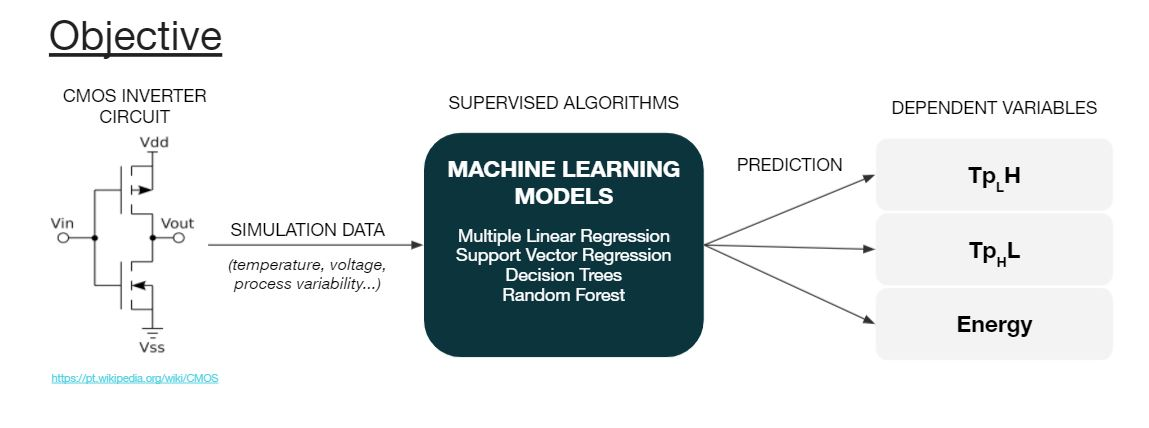

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import logging

In [2]:
!pwd

/home/orion23/Desktop/Electrical-Behaviour-Prediction/FINFET/7nm/NOT/Models/sim1


In [79]:
results_dir = "../../../Models/sim1/result/"

In [3]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='results_log.txt', mode='a')
logger.setLevel(logging.INFO)#send two messages to the logger
logger.addHandler(fhandler)

In [4]:
path = "../../Data/sim1/simResults_NOTfet"
os.chdir(path)
print("Current path:", os.getcwd())
print("Files:")
for file in os.listdir():
  print(" ", file)

Current path: /home/orion23/Desktop/Electrical-Behaviour-Prediction/FINFET/7nm/NOT/Data/sim1/simResults_NOTfet
Files:
  all_results_inverter.csv
  completed.csv
  log.txt
  parameters.json
  cases.csv
  treated_data_inverter.csv


# Ajustando o .csv

In [38]:
data = pd.read_csv('all_results_inverter.csv', index_col=0)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 0 to 47999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1                     48000 non-null  float64
 1   2                     48000 non-null  float64
 2   LoadCap               48000 non-null  object 
 3   vdd                   48000 non-null  float64
 4   number_fin            48000 non-null  int64  
 5   index                 48000 non-null  int64  
 6   temp                  48000 non-null  int64  
 7   montecarlo_iteration  48000 non-null  int64  
 8   tphl                  48000 non-null  float64
 9   tplh                  48000 non-null  float64
 10  total_power           48000 non-null  float64
 11  iint                  48000 non-null  float64
 12  temper                48000 non-null  int64  
 13  alter#                48000 non-null  int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 5.5+ MB


In [40]:
#data = data.apply(pd.to_numeric, errors='coerce')
data.isna().sum()

1                       0
2                       0
LoadCap                 0
vdd                     0
number_fin              0
index                   0
temp                    0
montecarlo_iteration    0
tphl                    0
tplh                    0
total_power             0
iint                    0
temper                  0
alter#                  0
dtype: int64

In [41]:
data = data.dropna()
data.isna().sum()

1                       0
2                       0
LoadCap                 0
vdd                     0
number_fin              0
index                   0
temp                    0
montecarlo_iteration    0
tphl                    0
tplh                    0
total_power             0
iint                    0
temper                  0
alter#                  0
dtype: int64

In [42]:
data = data.rename(columns={'1': 'nfetPhig', 
                            '2': 'pfetPhig', 
                            'alter#': 'alter', 
                            'vdd': 'voltage', 
                            'LoadCap': 'capacitance',
                            'temp': 'temperature',
                            'number_fin': 'finsNumber',
                            'montecarlo_iteration': 'monteCarloIteration',
                            'total_power': 'totalPower',
                            'iint': 'energy',
                            'tphl': 'tphL',
                            'tplh': 'tplH'
                            })

data = data.drop("temper", axis=1)
data = data.drop("alter", axis=1)
data = data.drop("index", axis=1)

data["finLength"] = 2.1e-8
data["finHeight"] = 3.2e-8

In [43]:
data["capacitance"] = data["capacitance"].map(lambda x: (float(x[:-1]))*10**(-15))

In [44]:
data.capacitance.unique()

array([1.0e-15, 4.0e-15, 8.0e-15, 1.6e-14])

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 0 to 47999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nfetPhig             48000 non-null  float64
 1   pfetPhig             48000 non-null  float64
 2   capacitance          48000 non-null  float64
 3   voltage              48000 non-null  float64
 4   finsNumber           48000 non-null  int64  
 5   temperature          48000 non-null  int64  
 6   monteCarloIteration  48000 non-null  int64  
 7   tphL                 48000 non-null  float64
 8   tplH                 48000 non-null  float64
 9   totalPower           48000 non-null  float64
 10  energy               48000 non-null  float64
 11  finLength            48000 non-null  float64
 12  finHeight            48000 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 5.1 MB


In [46]:
data.to_csv('treated_data_inverter.csv') 
#""""!cp treated_data.csv "/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data" #copiar para o drive!"""

# Limpando e Explorando os Dados

In [47]:
data = pd.read_csv("treated_data_inverter.csv", index_col=0)
data.head()

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,monteCarloIteration,tphL,tplH,totalPower,energy,finLength,finHeight
0,4.370067,4.852864,1.000000e-15,0.6,1,-25,1,1.230100e-11,1.582600e-11,-9.601460e-09,-6.400970e-16,2.100000e-08,3.200000e-08
1,4.370806,4.873612,1.000000e-15,0.6,1,-25,2,1.232850e-11,1.470250e-11,-9.648810e-09,-6.432540e-16,2.100000e-08,3.200000e-08
2,4.333499,4.850897,1.000000e-15,0.6,1,-25,3,1.128970e-11,1.594150e-11,-9.603980e-09,-6.402650e-16,2.100000e-08,3.200000e-08
3,4.407237,4.856645,1.000000e-15,0.6,1,-25,4,1.353270e-11,1.560170e-11,-9.595290e-09,-6.396860e-16,2.100000e-08,3.200000e-08
4,4.387795,4.770993,1.000000e-15,0.6,1,-25,5,1.282430e-11,2.289280e-11,-9.530360e-09,-6.353580e-16,2.100000e-08,3.200000e-08


In [48]:
inp_var = ["capacitance", "voltage", "finHeight", "finLength", "temperature", "finsNumber"]
unique = {}
for col in inp_var:
  unique[col] = list(np.sort(data[col].unique()))
tmp = data[inp_var]
# Verifica quantas vezes o mesmo caso é repetido
n_repetitions = tmp.shape[0]
for i in range(1, tmp.shape[0]):
  if (not tmp.iloc[0].equals(tmp.iloc[i])):
    n_repetitions = i
    break

n_cases = tmp.shape[0]//n_repetitions
idx = []
idx.append(np.vstack([np.arange(n_cases)]*n_repetitions).T.reshape(-1))
idx.append(np.concatenate([np.arange(n_repetitions)]*n_cases))
data.index = pd.MultiIndex.from_tuples(list(zip(*idx)), names=["case", "idx"])
data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber  temperature  \
case idx                                                                       
0    0    4.370067  4.852864  1.000000e-15      0.6           1          -25   
     1    4.370806  4.873612  1.000000e-15      0.6           1          -25   
     2    4.333499  4.850897  1.000000e-15      0.6           1          -25   
     3    4.407237  4.856645  1.000000e-15      0.6           1          -25   
     4    4.387795  4.770993  1.000000e-15      0.6           1          -25   
...            ...       ...           ...      ...         ...          ...   
479  95   4.336670  4.776053  1.600000e-14      0.9           5          100   
     96   4.379719  4.855940  1.600000e-14      0.9           5          100   
     97   4.435190  4.791605  1.600000e-14      0.9           5          100   
     98   4.323838  4.781360  1.600000e-14      0.9           5          100   
     99   4.359071  4.791511  1.600000e-14      0.9           5          100   

          monteCarloIteration          tphL          tplH    totalPower  \
case idx                                                                  
0    0                      1  1.230100e-11  1.582600e-11 -9.601460e-09   
     1                      2  1.232850e-11  1.470250e-11 -9.648810e-09   
     2                      3  1.128970e-11  1.594150e-11 -9.603980e-09   
     3                      4  1.353270e-11  1.560170e-11 -9.595290e-09   
     4                      5  1.282430e-11  2.289280e-11 -9.530360e-09   
...                       ...           ...           ...           ...   
479  95                    96  3.889300e-11  3.870920e-11 -4.524430e-07   
     96                    97  4.406050e-11  3.445420e-11 -1.128870e-06   
     97                    98  5.173240e-11  3.773370e-11 -5.086850e-07   
     98                    99  3.772690e-11  3.840220e-11 -4.723270e-07   
     99                   100  4.121160e-11  3.778920e-11 -5.105290e-07   

                energy     finLength     finHeight  
case idx                                            
0    0   -6.400970e-16  2.100000e-08  3.200000e-08  
     1   -6.432540e-16  2.100000e-08  3.200000e-08  
     2   -6.402650e-16  2.100000e-08  3.200000e-08  
     3   -6.396860e-16  2.100000e-08  3.200000e-08  
     4   -6.353580e-16  2.100000e-08  3.200000e-08  
...                ...           ...           ...  
479  95  -2.010860e-14  2.100000e-08  3.200000e-08  
     96  -5.017210e-14  2.100000e-08  3.200000e-08  
     97  -2.260820e-14  2.100000e-08  3.200000e-08  
     98  -2.099230e-14  2.100000e-08  3.200000e-08  
     99  -2.269020e-14  2.100000e-08  3.200000e-08  

[48000 rows x 13 columns]

In [49]:
from scipy.stats import zscore
out_var = ["tphL", "tplH", "energy", "totalPower"]
filtered_list = []
for case in data.index.unique(level="case"):
    tmp = data.loc[slice(case, case), :]
    not_outlier = (np.abs(zscore(tmp[out_var])) < 3).all(axis=1)
    filtered_list.append(tmp[not_outlier])
filtered = pd.concat(filtered_list)
filtered

nfetPhig  pfetPhig   capacitance  voltage  finsNumber  temperature  \
case idx                                                                       
0    0    4.370067  4.852864  1.000000e-15      0.6           1          -25   
     1    4.370806  4.873612  1.000000e-15      0.6           1          -25   
     2    4.333499  4.850897  1.000000e-15      0.6           1          -25   
     3    4.407237  4.856645  1.000000e-15      0.6           1          -25   
     4    4.387795  4.770993  1.000000e-15      0.6           1          -25   
...            ...       ...           ...      ...         ...          ...   
479  95   4.336670  4.776053  1.600000e-14      0.9           5          100   
     96   4.379719  4.855940  1.600000e-14      0.9           5          100   
     97   4.435190  4.791605  1.600000e-14      0.9           5          100   
     98   4.323838  4.781360  1.600000e-14      0.9           5          100   
     99   4.359071  4.791511  1.600000e-14      0.9           5          100   

          monteCarloIteration          tphL          tplH    totalPower  \
case idx                                                                  
0    0                      1  1.230100e-11  1.582600e-11 -9.601460e-09   
     1                      2  1.232850e-11  1.470250e-11 -9.648810e-09   
     2                      3  1.128970e-11  1.594150e-11 -9.603980e-09   
     3                      4  1.353270e-11  1.560170e-11 -9.595290e-09   
     4                      5  1.282430e-11  2.289280e-11 -9.530360e-09   
...                       ...           ...           ...           ...   
479  95                    96  3.889300e-11  3.870920e-11 -4.524430e-07   
     96                    97  4.406050e-11  3.445420e-11 -1.128870e-06   
     97                    98  5.173240e-11  3.773370e-11 -5.086850e-07   
     98                    99  3.772690e-11  3.840220e-11 -4.723270e-07   
     99                   100  4.121160e-11  3.778920e-11 -5.105290e-07   

                energy     finLength     finHeight  
case idx                                            
0    0   -6.400970e-16  2.100000e-08  3.200000e-08  
     1   -6.432540e-16  2.100000e-08  3.200000e-08  
     2   -6.402650e-16  2.100000e-08  3.200000e-08  
     3   -6.396860e-16  2.100000e-08  3.200000e-08  
     4   -6.353580e-16  2.100000e-08  3.200000e-08  
...                ...           ...           ...  
479  95  -2.010860e-14  2.100000e-08  3.200000e-08  
     96  -5.017210e-14  2.100000e-08  3.200000e-08  
     97  -2.260820e-14  2.100000e-08  3.200000e-08  
     98  -2.099230e-14  2.100000e-08  3.200000e-08  
     99  -2.269020e-14  2.100000e-08  3.200000e-08  

[45744 rows x 13 columns]

In [50]:
df = filtered.copy()
#df = data.copy()
df

nfetPhig  pfetPhig   capacitance  voltage  finsNumber  temperature  \
case idx                                                                       
0    0    4.370067  4.852864  1.000000e-15      0.6           1          -25   
     1    4.370806  4.873612  1.000000e-15      0.6           1          -25   
     2    4.333499  4.850897  1.000000e-15      0.6           1          -25   
     3    4.407237  4.856645  1.000000e-15      0.6           1          -25   
     4    4.387795  4.770993  1.000000e-15      0.6           1          -25   
...            ...       ...           ...      ...         ...          ...   
479  95   4.336670  4.776053  1.600000e-14      0.9           5          100   
     96   4.379719  4.855940  1.600000e-14      0.9           5          100   
     97   4.435190  4.791605  1.600000e-14      0.9           5          100   
     98   4.323838  4.781360  1.600000e-14      0.9           5          100   
     99   4.359071  4.791511  1.600000e-14      0.9           5          100   

          monteCarloIteration          tphL          tplH    totalPower  \
case idx                                                                  
0    0                      1  1.230100e-11  1.582600e-11 -9.601460e-09   
     1                      2  1.232850e-11  1.470250e-11 -9.648810e-09   
     2                      3  1.128970e-11  1.594150e-11 -9.603980e-09   
     3                      4  1.353270e-11  1.560170e-11 -9.595290e-09   
     4                      5  1.282430e-11  2.289280e-11 -9.530360e-09   
...                       ...           ...           ...           ...   
479  95                    96  3.889300e-11  3.870920e-11 -4.524430e-07   
     96                    97  4.406050e-11  3.445420e-11 -1.128870e-06   
     97                    98  5.173240e-11  3.773370e-11 -5.086850e-07   
     98                    99  3.772690e-11  3.840220e-11 -4.723270e-07   
     99                   100  4.121160e-11  3.778920e-11 -5.105290e-07   

                energy     finLength     finHeight  
case idx                                            
0    0   -6.400970e-16  2.100000e-08  3.200000e-08  
     1   -6.432540e-16  2.100000e-08  3.200000e-08  
     2   -6.402650e-16  2.100000e-08  3.200000e-08  
     3   -6.396860e-16  2.100000e-08  3.200000e-08  
     4   -6.353580e-16  2.100000e-08  3.200000e-08  
...                ...           ...           ...  
479  95  -2.010860e-14  2.100000e-08  3.200000e-08  
     96  -5.017210e-14  2.100000e-08  3.200000e-08  
     97  -2.260820e-14  2.100000e-08  3.200000e-08  
     98  -2.099230e-14  2.100000e-08  3.200000e-08  
     99  -2.269020e-14  2.100000e-08  3.200000e-08  

[45744 rows x 13 columns]

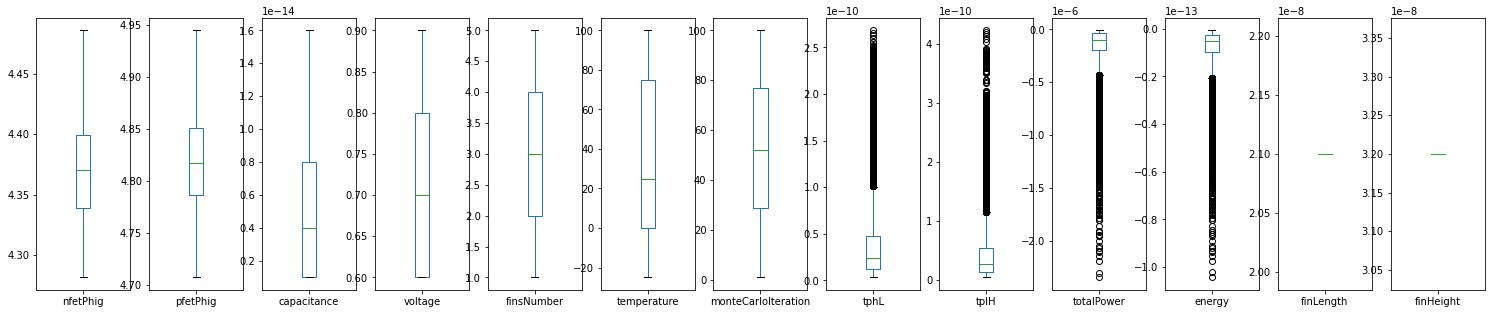

<Figure size 432x288 with 0 Axes>

In [51]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
_ = plt.figure()
plt.show()

In [52]:
df.describe()

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,monteCarloIteration,tphL,tplH,totalPower,energy,finLength,finHeight
count,45744.000000,45744.000000,4.574400e+04,45744.000000,45744.000000,45744.000000,45744.000000,4.574400e+04,4.574400e+04,4.574400e+04,4.574400e+04,4.574400e+04,4.574400e+04
mean,4.370088,4.816262,7.245868e-15,0.749550,3.000568,37.429499,52.036201,3.792413e-11,4.355032e-11,-1.407965e-07,-7.098094e-15,2.100000e-08,3.200000e-08
std,0.038073,0.045098,5.627818e-15,0.111915,1.414244,42.712674,28.541462,4.006924e-11,4.746161e-11,1.589090e-07,7.104347e-15,6.617517e-24,6.617517e-24
min,4.281295,4.706879,1.000000e-15,0.600000,1.000000,-25.000000,1.000000,3.254290e-12,3.605230e-12,-2.349200e-06,-1.044090e-13,2.100000e-08,3.200000e-08
25%,4.338812,4.786095,1.000000e-15,0.600000,2.000000,0.000000,29.000000,1.188140e-11,1.300068e-11,-1.968898e-07,-9.845200e-15,2.100000e-08,3.200000e-08
50%,4.370806,4.816507,4.000000e-15,0.700000,3.000000,25.000000,52.000000,2.393770e-11,2.723240e-11,-9.902155e-08,-5.121030e-15,2.100000e-08,3.200000e-08
75%,4.399214,4.850897,8.000000e-15,0.800000,4.000000,75.000000,77.000000,4.742910e-11,5.384630e-11,-3.870477e-08,-2.548488e-15,2.100000e-08,3.200000e-08
max,4.486197,4.944579,1.600000e-14,0.900000,5.000000,100.000000,100.000000,2.681820e-10,4.233190e-10,-9.494180e-09,-6.329450e-16,2.100000e-08,3.200000e-08


In [53]:
df['finsNumber'].value_counts()

5    9156
2    9150
3    9148
4    9148
1    9142
Name: finsNumber, dtype: int64

In [54]:
df['temperature'].value_counts()

-25     7655
 0      7627
 25     7620
 50     7618
 100    7614
 75     7610
Name: temperature, dtype: int64

## Alterando a escala

### Escalando pelo MinMaxScaler

In [55]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_scaled[["energy", "tphL", "tplH"]])

MinMaxScaler()

In [56]:
print(minMaxScaler.data_max_)
print(minMaxScaler.data_min_)

[-6.32945e-16  2.68182e-10  4.23319e-10]
[-1.04409e-13  3.25429e-12  3.60523e-12]


In [57]:
df_scaled[["energy", "tphL", "tplH"]] = minMaxScaler.transform(df_scaled[["energy", "tphL", "tplH"]])

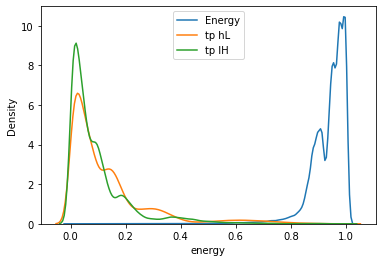

In [58]:
sns.kdeplot(df_scaled.energy, label = 'Energy')
sns.kdeplot(df_scaled.tphL, label = 'tp hL')
sns.kdeplot(df_scaled.tplH, label = 'tp lH')
plt.legend()
#plt.savefig(results_dir + 'normalized_targets.pdf') 
plt.show()

Muito melhor, agora todos estão na mesma escala. Ainda assim, quero testar uma outra estratégia, a qual consiste em apenas remover a maginitude dos valores para eles ficarem menos próximos de zero. Até porque o detalhe em fazer essa técnica de cima é que estou escalando os valores antes de fazer o training dataset, o que não é uma prática comum e estou fazendo apenas para os target values

## Correlações

### Visualizações (demoram muito para rodar! >1h Cuidado)

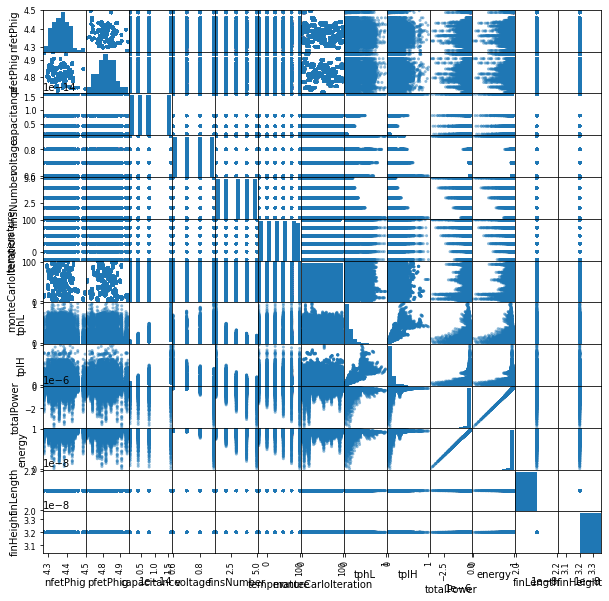

<Figure size 432x288 with 0 Axes>

In [117]:
pd.plotting.scatter_matrix(df_scaled, figsize=(10,10))
plt.figure()
plt.show()

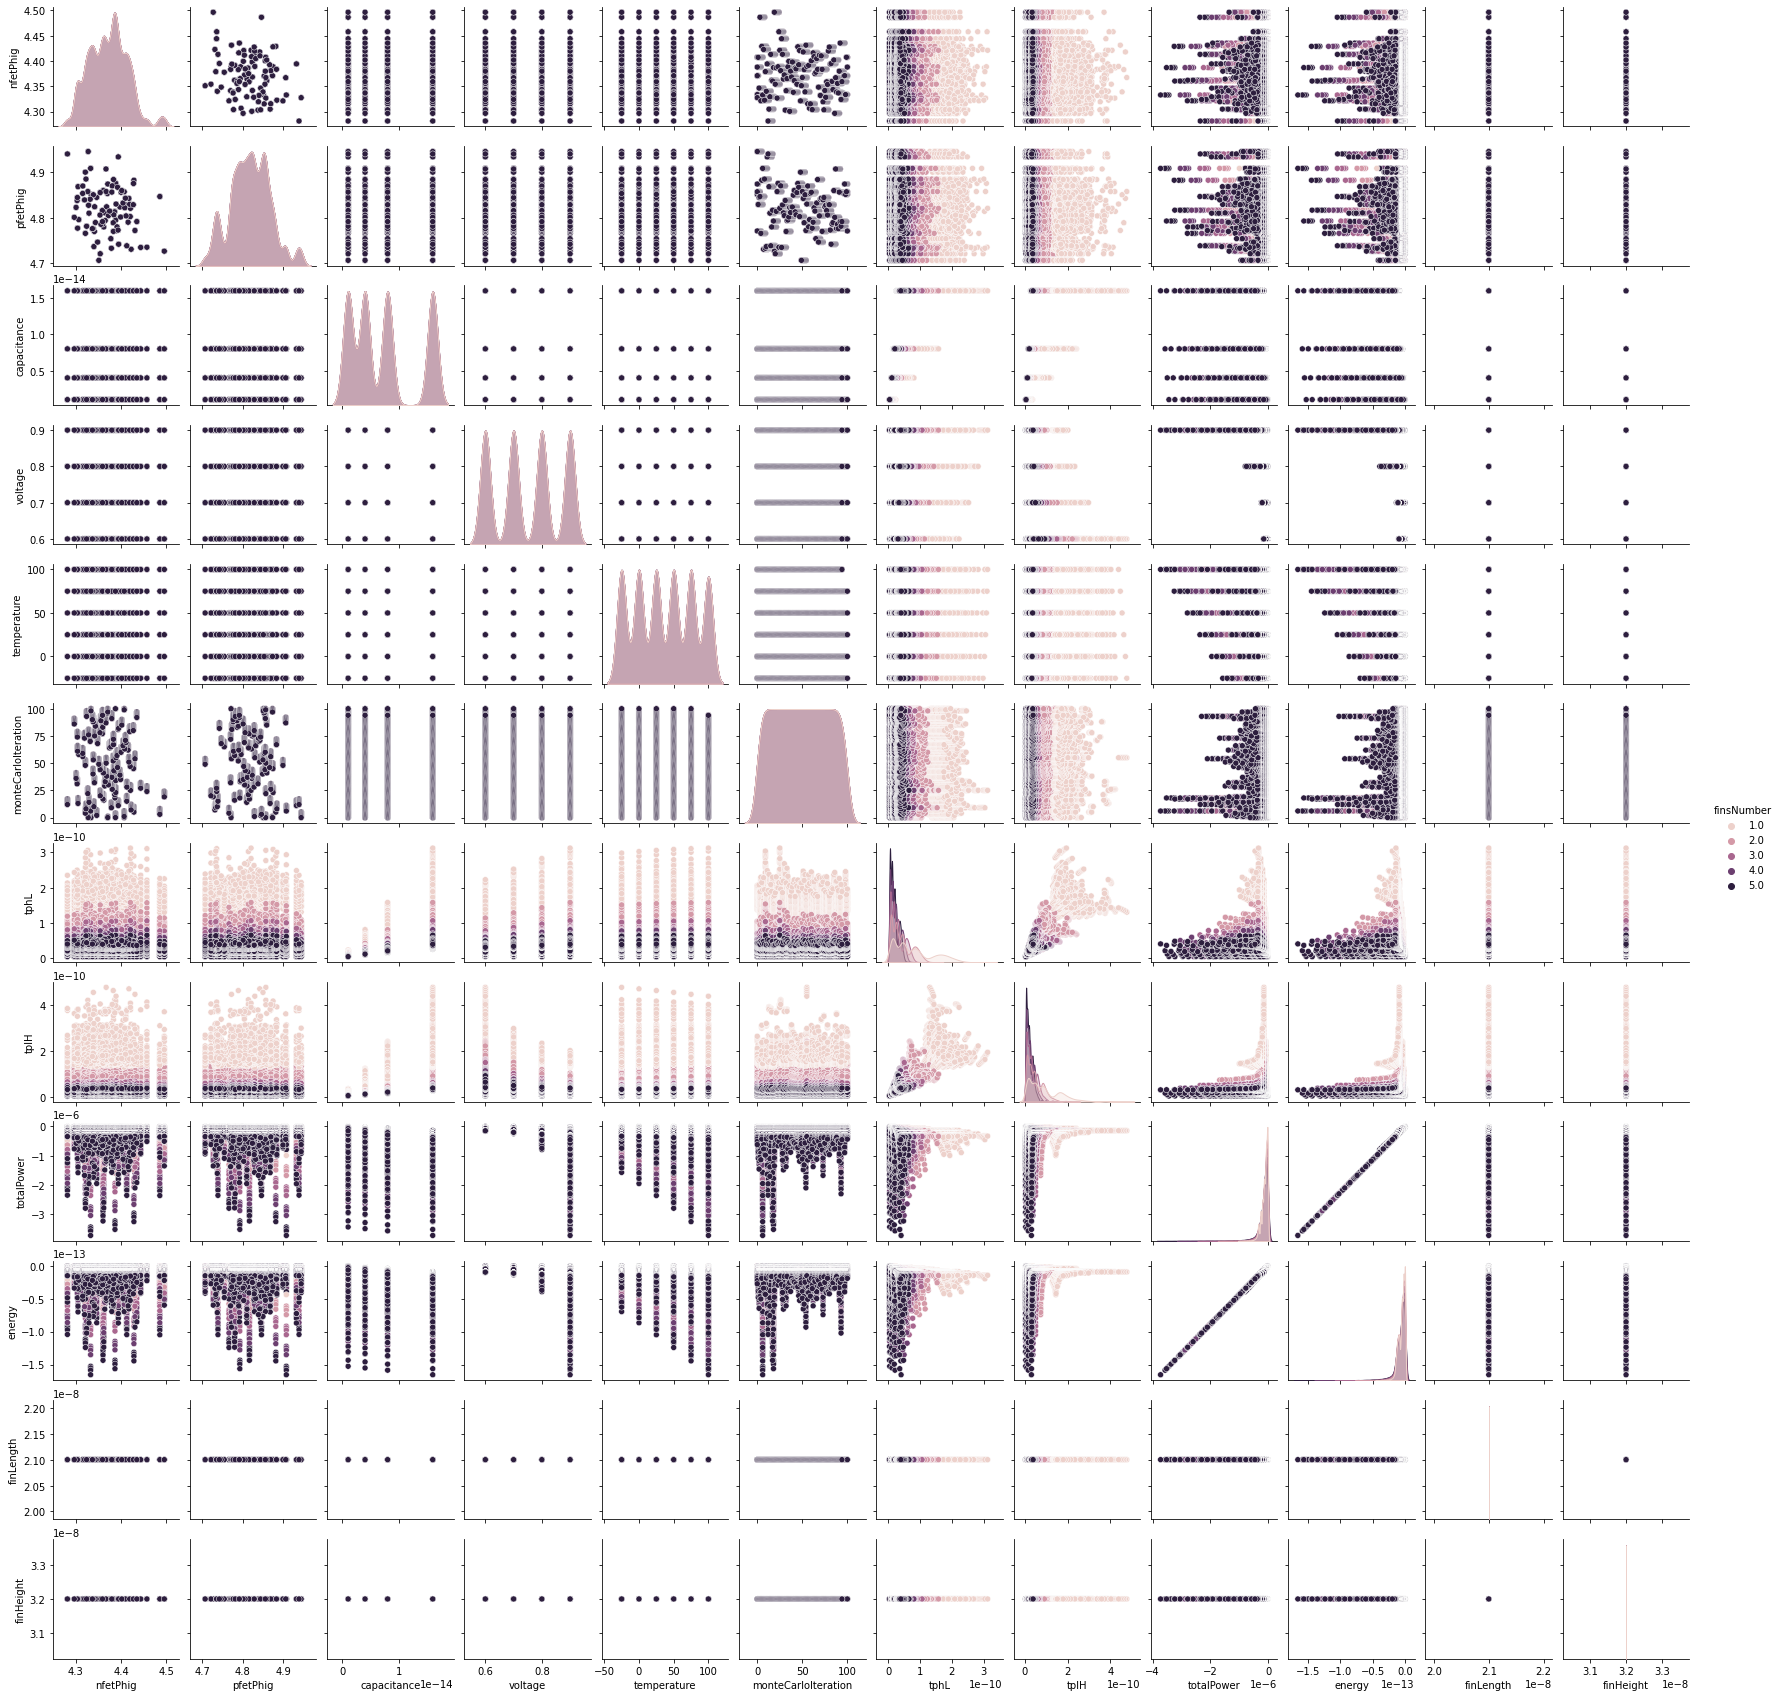

In [119]:
_ = sns.pairplot(df, hue="finsNumber", height=2, diag_kind="kde")
plt.show()

In [ ]:
_ = sns.pairplot(df, hue="temperature", height=2, diag_kind="kde")
plt.show()

### Pearson

In [28]:
temp_data = df_scaled.copy()

#temp_data = temp_data.drop(columns=['energy', 'tphL','tplH'])

In [29]:
temp_data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber  temperature  \
case idx                                                                       
0    0    4.370067  4.852864  1.000000e-15      0.6           1          -25   
     1    4.370806  4.873612  1.000000e-15      0.6           1          -25   
     2    4.333499  4.850897  1.000000e-15      0.6           1          -25   
     3    4.407237  4.856645  1.000000e-15      0.6           1          -25   
     4    4.387795  4.770993  1.000000e-15      0.6           1          -25   
...            ...       ...           ...      ...         ...          ...   
479  95   4.336670  4.776053  1.600000e-14      0.9           5          100   
     96   4.379719  4.855940  1.600000e-14      0.9           5          100   
     97   4.435190  4.791605  1.600000e-14      0.9           5          100   
     98   4.323838  4.781360  1.600000e-14      0.9           5          100   
     99   4.359071  4.791511  1.600000e-14      0.9           5          100   

          monteCarloIteration      tphL      tplH    totalPower    energy  \
case idx                                                                    
0    0                      1  0.034148  0.029117 -9.601460e-09  0.999931   
     1                      2  0.034252  0.026440 -9.648810e-09  0.999901   
     2                      3  0.030331  0.029392 -9.603980e-09  0.999929   
     3                      4  0.038797  0.028583 -9.595290e-09  0.999935   
     4                      5  0.036123  0.045954 -9.530360e-09  0.999977   
...                       ...       ...       ...           ...       ...   
479  95                    96  0.134522  0.083638 -4.524430e-07  0.812330   
     96                    97  0.154028  0.073500 -1.128870e-06  0.522634   
     97                    98  0.182986  0.081314 -5.086850e-07  0.788243   
     98                    99  0.130121  0.082906 -4.723270e-07  0.803815   
     99                   100  0.143274  0.081446 -5.105290e-07  0.787453   

             finLength     finHeight  
case idx                              
0    0    2.100000e-08  3.200000e-08  
     1    2.100000e-08  3.200000e-08  
     2    2.100000e-08  3.200000e-08  
     3    2.100000e-08  3.200000e-08  
     4    2.100000e-08  3.200000e-08  
...                ...           ...  
479  95   2.100000e-08  3.200000e-08  
     96   2.100000e-08  3.200000e-08  
     97   2.100000e-08  3.200000e-08  
     98   2.100000e-08  3.200000e-08  
     99   2.100000e-08  3.200000e-08  

[45744 rows x 13 columns]

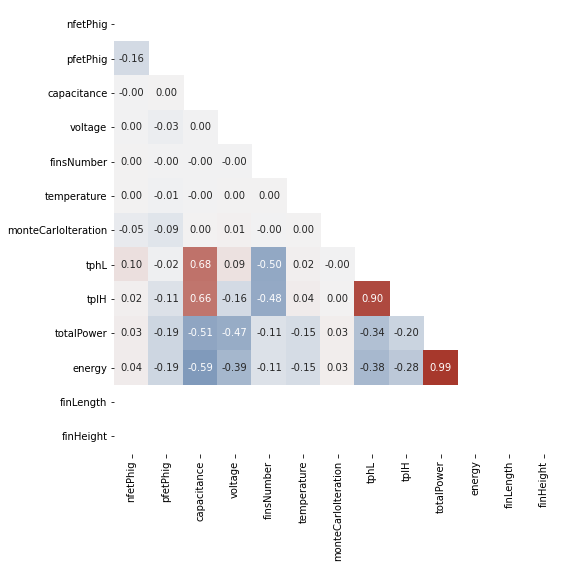

In [36]:
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(temp_data.corr(), dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(temp_data.corr(), mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig(results_dir + 'pearson.pdf') 
plt.show()

### Kendall

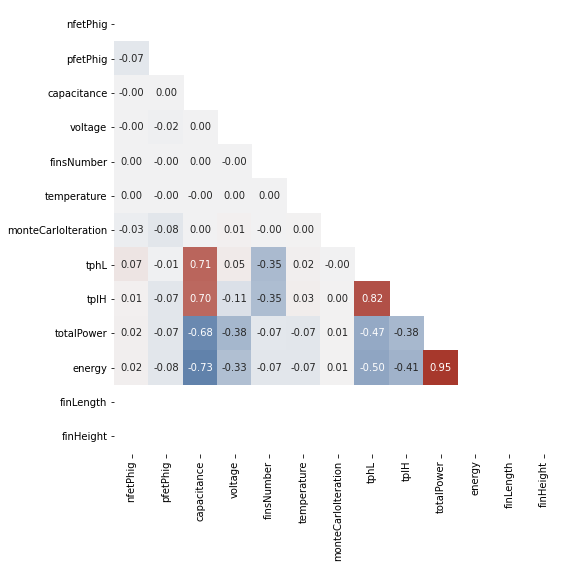

In [37]:
kendall = df.corr(method='kendall')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(kendall, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(kendall, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig(results_dir + 'kendall.pdf') 
plt.show()

### Spearman

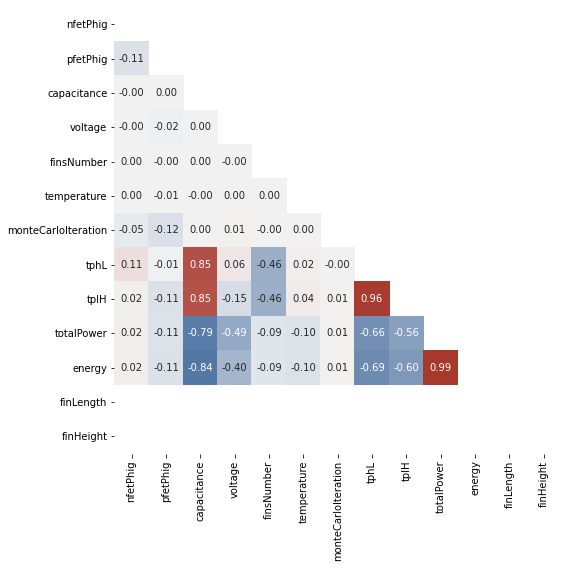

In [38]:
spearman = df.corr(method='spearman')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(spearman, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(spearman, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig(results_dir + 'spearman.pdf') 
plt.show()

# Metrics

In [59]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(_error(actual[seasonality:], _naive_forecasting(actual, seasonality)))
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(np.sum(np.square(_error(actual, predicted) - __mae))/(len(actual) - 1))


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(np.sum(np.square(_percentage_error(actual, predicted) - __mape))/(len(actual) - 1))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual))))


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(np.sum(np.square(actual - predicted)) / np.sum(np.square(actual - np.mean(actual))))


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


METRICS = {
    'mse': mse,
    'rmse': rmse,
    'nrmse': nrmse,
    'me': me,
    'mae': mae,
    'mad': mad,
    'gmae': gmae,
    'mdae': mdae,
    'mpe': mpe,
    'mape': mape,
    'mdape': mdape,
    'smape': smape,
    'smdape': smdape,
    'maape': maape,
    'mase': mase,
    'std_ae': std_ae,
    'std_ape': std_ape,
    'rmspe': rmspe,
    'rmdspe': rmdspe,
    'rmsse': rmsse,
    'inrse': inrse,
    'rrse': rrse,
    'mre': mre,
    'rae': rae,
    'mrae': mrae,
    'mdrae': mdrae,
    'gmrae': gmrae,
    'mbrae': mbrae,
    'umbrae': umbrae,
    'mda': mda,
}


def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('mae', 'mse', 'smape', 'umbrae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [60]:
from sklearn.preprocessing import Normalizer
def mape_normalized(actual, pred, plus_one = False):
  norm_actual = Normalizer().fit_transform(actual.reshape(-1, 1))
  norm_pred = Normalizer().fit_transform(pred.reshape(-1, 1))
  if plus_one:
    norm_actual = norm_actual + 1
    norm_pred = norm_pred + 1
  return mape(norm_actual, norm_pred)

# Train, Validation, Test Sets

Apenas testando para o Atraso de Descida

In [61]:
X = df_scaled.drop(columns=['tphL', 'tplH', 'energy', 'totalPower','monteCarloIteration'])
y = df_scaled[['tphL', 'tplH', 'energy']]

logging.info("X.shape: {}\n".format(X.shape))
logging.info("y.shape: {}\n".format(y.shape))
print(X.shape)
print(y.shape)

(45744, 8)
(45744, 3)


In [62]:
X.describe()

,nfetPhig,pfetPhig,capacitance,voltage,finsNumber,temperature,finLength,finHeight
count,45744.000000,45744.000000,4.574400e+04,45744.000000,45744.000000,45744.000000,4.574400e+04,4.574400e+04
mean,4.370088,4.816262,7.245868e-15,0.749550,3.000568,37.429499,2.100000e-08,3.200000e-08
std,0.038073,0.045098,5.627818e-15,0.111915,1.414244,42.712674,6.617517e-24,6.617517e-24
min,4.281295,4.706879,1.000000e-15,0.600000,1.000000,-25.000000,2.100000e-08,3.200000e-08
25%,4.338812,4.786095,1.000000e-15,0.600000,2.000000,0.000000,2.100000e-08,3.200000e-08
50%,4.370806,4.816507,4.000000e-15,0.700000,3.000000,25.000000,2.100000e-08,3.200000e-08
75%,4.399214,4.850897,8.000000e-15,0.800000,4.000000,75.000000,2.100000e-08,3.200000e-08
max,4.486197,4.944579,1.600000e-14,0.900000,5.000000,100.000000,2.100000e-08,3.200000e-08


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 23

Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=seed, test_size=0.25)

# grellert esse é o mais recomendado
scaler = StandardScaler().fit(Xtr)
Xtr_sc = scaler.transform(Xtr)
Xte_sc = scaler.transform(Xte)

X_train, X_val, y_train, y_val = train_test_split(Xtr_sc, ytr, random_state=seed, test_size=0.33)

logging.info("Test set X {}\n".format(Xte.shape))
logging.info("Test set y {}\n".format(yte.shape))
logging.info("Train set X {}\n".format(X_train.shape))
logging.info("Train set y {}\n".format(y_train.shape))
logging.info("Validation set X {}\n".format(X_val.shape))
logging.info("Validation set y {}\n".format(y_val.shape))

print("Test set X", Xte.shape)
print("Test set y", yte.shape)
print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (11436, 8)
Test set y (11436, 3)
Train set X (22986, 8)
Train set y (22986, 3)
Validation set X (11322, 8)
Validation set y (11322, 3)


In [64]:
y_train.describe()

,tphL,tplH,energy
count,22986.000000,22986.000000,22986.000000
mean,0.130435,0.094617,0.937931
std,0.150341,0.111743,0.067934
min,0.000336,0.000452,0.000000
25%,0.032418,0.022213,0.911126
50%,0.077533,0.056118,0.957079
75%,0.167004,0.119861,0.981520
max,1.000000,1.000000,1.000000


# New Models


In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## Shortlisting

In [83]:
clfs = [RandomForestRegressor(), LinearRegression(), SVR(kernel='rbf'), DecisionTreeRegressor()]

label: tphL
clf: RandomForestRegressor, mse: 2.5275057560824215e-06, r2: 0.9998912157642901
clf: LinearRegression, mse: 0.0062930721041835145, r2: 0.7291452106592293
clf: SVR, mse: 0.001946093399418092, r2: 0.9162398413667563
clf: DecisionTreeRegressor, mse: 5.577826680997829e-06, r2: 0.9997599294834622
label: tplH
clf: RandomForestRegressor, mse: 2.1084358983131853e-06, r2: 0.9998364523484061
clf: LinearRegression, mse: 0.00378541595801009, r2: 0.7063719647659905
clf: SVR, mse: 0.0016972211746024714, r2: 0.8683495487988447
clf: DecisionTreeRegressor, mse: 4.375974941210322e-06, r2: 0.9996605633466774


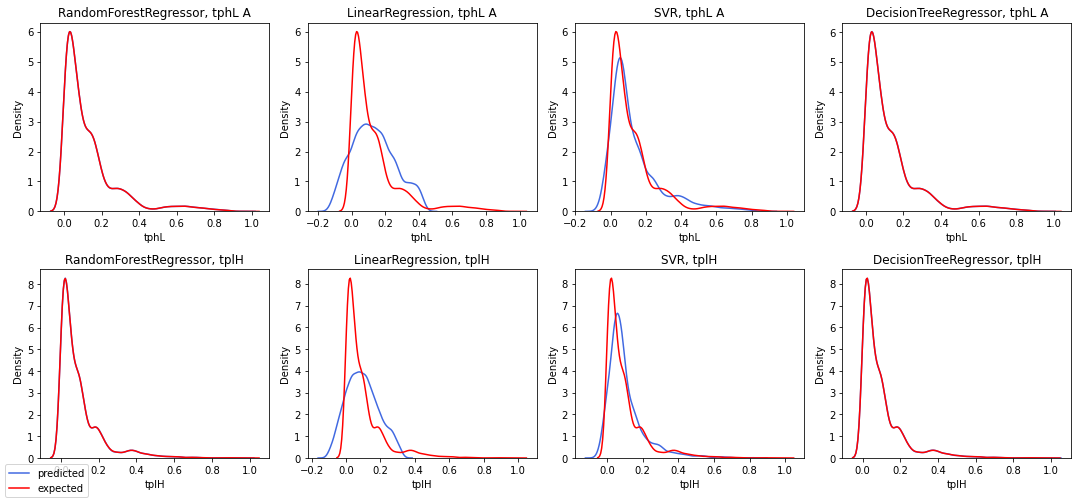

In [84]:
fig, ax = plt.subplots(2,4, figsize = (15,7))
#modelos para TPHL
logging.info('\nlabel: tphL')
print('label: tphL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphL), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphL), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0][i], color = 'red')
    ax[0][i].set_title(f'{clf.__class__.__name__}, tphL A')

#modelos para TPLH
print('label: tplH')
logging.info('\nlabel: tplH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplH), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplH), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1][i], color = 'red')
    ax[1][i].set_title(f'{clf.__class__.__name__}, tplH')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc='lower left')
#plt.savefig(results_dir + 'delays_inverter.pdf') 
plt.show()

label: tphL
clf: RandomForestRegressor, mse: 2.4452293151810487e-06, r2: 0.9998947569549358
clf: LinearRegression, mse: 0.0062930721041835145, r2: 0.7291452106592293
clf: SVR, mse: 0.001946093399418092, r2: 0.9162398413667563
clf: DecisionTreeRegressor, mse: 5.5502447560456e-06, r2: 0.9997611166137459


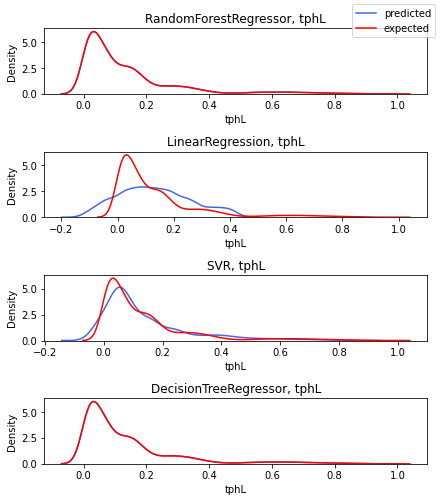

In [85]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPHL = {}

#modelos para TPHL
print('label: tphL')
logging.info('\nlabel: tphL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    pred_TPHL['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphla), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphla), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tphL')
    
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'tphL_inverter.pdf') 
#plt.xlim([-0.05, 0.5])
plt.show()

label: tplH
clf: RandomForestRegressor, mse: 2.1583093806162943e-06, r2: 0.9998325837504023
clf: LinearRegression, mse: 0.00378541595801009, r2: 0.7063719647659905
clf: SVR, mse: 0.0016972211746024714, r2: 0.8683495487988447
clf: DecisionTreeRegressor, mse: 4.573849764627734e-06, r2: 0.999645214545841


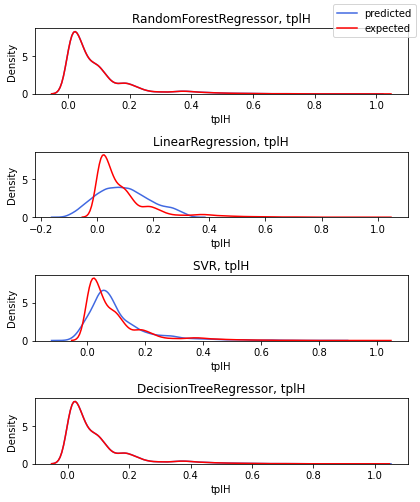

In [86]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPLH = {}
print('label: tplH')
logging.info('\nlabel: tplH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    pred_TPLH['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplH), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplH), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tplH')
    ax[i].set(xlabel='tplH')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'tplH_inverter.pdf')
plt.show()

label: Energy
clf: RandomForestRegressor, mse: 1.7336671937678314e-05, r2: 0.9962273203103149
clf: LinearRegression, mse: 0.0018602515190401716, r2: 0.5951856764194716
clf: SVR, mse: 0.002426227117814842, r2: 0.4720222080196347
clf: DecisionTreeRegressor, mse: 4.177701963685611e-05, r2: 0.9909087906810417


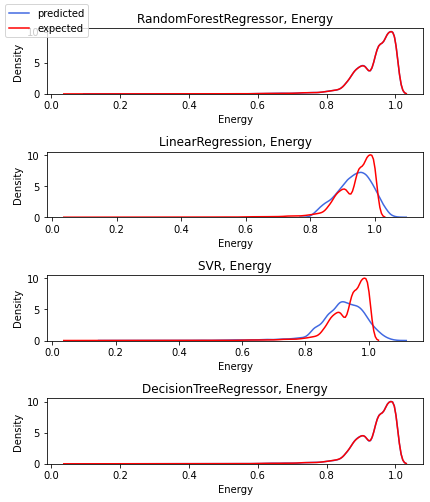

In [87]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
logging.info('\nlabel: Energy')
print('label: Energy')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.energy), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.energy), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, Energy')
    ax[i].set(xlabel='Energy')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc="upper left")
#plt.savefig(results_dir + 'energy_inverter.pdf')
plt.show()

Time to Fine-tune! Seguir com SVR (...) e o Random Forest

# Inference Time

In [88]:
import time

In [89]:
test_case = X_val[1,:]

In [91]:
#def pred_time(clfs: dict, value: np.array): -> List

##TPLH
print("\n TPLH")
logging.info("\n ==== time ====")
logging.info("\n TPLH")
for k in pred_TPLH.values():
  start_time = time.time()
  k_pred = k.predict(test_case.reshape(1, -1))
  value = time.time() - start_time
  print("{}: {:.5f} secs".format(k, value))
  logging.info("{}: {} secs".format(k, value))



##TPHL
print("\n TPHL")
logging.info("\n TPHL")
for a in pred_TPHL.values():
  start_time = time.time()
  a_pred = a.predict(test_case.reshape(1, -1))
  value = time.time() - start_time
  print("{}: {:.5f} secs".format(a.__class__.__name__, value))
  logging.info("{}: {} secs".format(a.__class__.__name__, value))

##IINT
print("\n IINT")
logging.info("\n IINT")
for b in pred_IINT.values():
  start_time = time.time()
  b_pred = b.predict(test_case.reshape(1, -1))
  value = time.time() - start_time
  print("{}: {:.5f} secs".format(b.__class__.__name__, value))
  logging.info("{}: {} secs".format(b.__class__.__name__, value))

  
###TPHL
#print("\n TPHLA")
#for a in pred_TPHLA.values():
#  start_time = time.time()
#  a_pred = a.predict(test_case.reshape(1, -1))
#  print("{}: {:.4f} secs".format(a.__class__.__name__, time.time() - start_time))

#print("\n TPLHB")
#for k in pred_TPLHB.values():
#  start_time = time.time()
#  k_pred = k.predict(test_case.reshape(1, -1))
#  print("{}: {:.4f} secs".format(k, time.time() - start_time))


 TPLH
RandomForestRegressor(): 0.00638 secs
LinearRegression(): 0.00012 secs
SVR(): 0.00012 secs
DecisionTreeRegressor(): 0.00008 secs

 TPHL
RandomForestRegressor: 0.00566 secs
LinearRegression: 0.00016 secs
SVR: 0.00014 secs
DecisionTreeRegressor: 0.00017 secs

 IINT
RandomForestRegressor: 0.00518 secs
LinearRegression: 0.00017 secs
SVR: 0.00016 secs
DecisionTreeRegressor: 0.00015 secs


# Fine-tuning

### Decision Tree

In [71]:
params = {'max_depth': [1, 2, 3, 4, 5, 6, 8]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

RF_model_cv_gs = DecisionTreeRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(RF_model_cv_gs, param_grid=params, return_train_score=True, cv=10) # valor padrão para quebras é 3

#### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))



#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
DF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
                                            
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 4}
Average Score on train set: 0.331 +/- 0.002
Average Score on validation set: 0.324 +/- 0.015

 Best hyperparameters:
{'max_depth': 4}
Average Score on train set: 0.342 +/- 0.001
Average Score on validation set: 0.336 +/- 0.012

 Best hyperparameters:
{'max_depth': 8}
Average Score on train set: 0.627 +/- 0.004
Average Score on validation set: 0.597 +/- 0.030


label: TPHL
clf: DecisionTreeRegressor, mse: 0.0006704375646792307, r2: 0.9711442643050897
label: TPLH
clf: DecisionTreeRegressor, mse: 0.0007406568297046794, r2: 0.9425485568557811
label: IINT
clf: DecisionTreeRegressor, mse: 0.00021603219063833927, r2: 0.9529886554426781


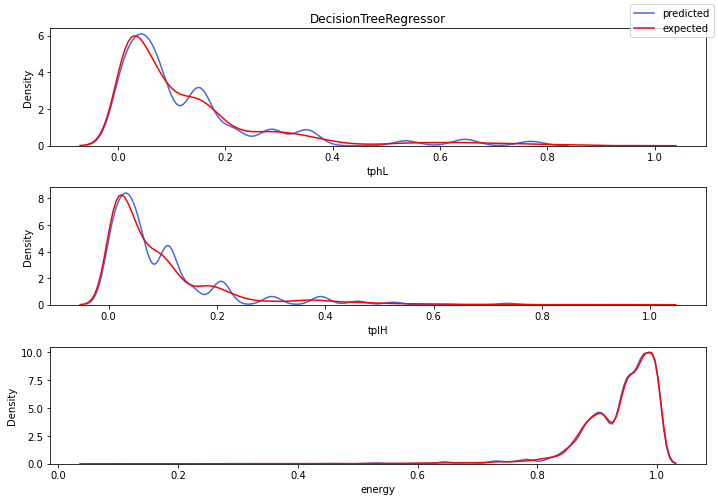

In [82]:
clfs = [DecisionTreeRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 4)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 4)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 8)
    clf = clf.fit(X_train, y_train.energy)
    
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'DT_all_best_hyperparams_inverter.pdf')
plt.show()


### Random Forest

In [70]:
params = {'n_estimators': [40, 45, 50, 73, 75],
          'max_depth': [4, 8, 9, 10, 15]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

RF_model_cv_gs = RandomForestRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(RF_model_cv_gs, param_grid=params, return_train_score=True, cv=10) # valor padrão para quebras é 3

#### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))



#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
RF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
                                            
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 4, 'n_estimators': 45}
Average Score on train set: 0.334 +/- 0.002
Average Score on validation set: 0.327 +/- 0.015

 Best hyperparameters:
{'max_depth': 4, 'n_estimators': 75}
Average Score on train set: 0.346 +/- 0.001
Average Score on validation set: 0.338 +/- 0.013

 Best hyperparameters:
{'max_depth': 8, 'n_estimators': 50}
Average Score on train set: 0.635 +/- 0.004
Average Score on validation set: 0.611 +/- 0.030


In [44]:
RF_cv_results_TPHL.to_csv(results_dir + 'RF_tphL_HyperParameters.csv')

In [45]:
RF_cv_results_TPLH.to_csv(results_dir + 'RF_tplH_HyperParameters.csv')

In [46]:
RF_cv_results_iint.to_csv(results_dir + 'RF_energy_HyperParameters.csv')

label: TPHL
clf: RandomForestRegressor, mse: 0.0006458525017823485, r2: 0.9722024091859401
label: TPLH
clf: RandomForestRegressor, mse: 0.0007175048846120055, r2: 0.9443444123772919
label: IINT
clf: RandomForestRegressor, mse: 9.280690626098351e-05, r2: 0.9798040401541904


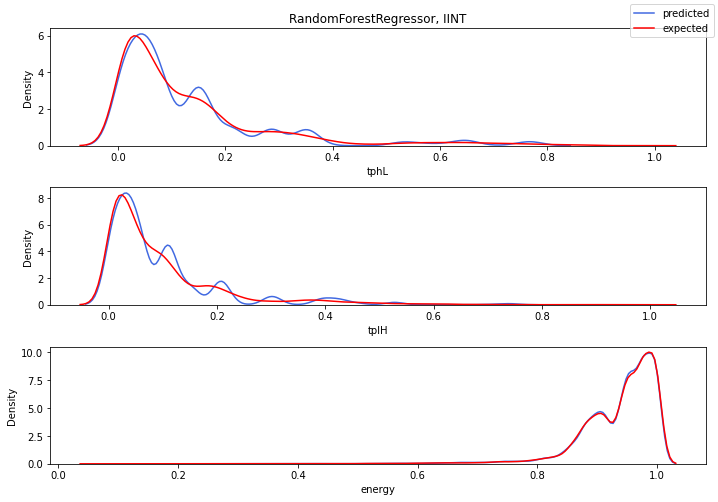

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [69]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 75,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 8)
    clf = clf.fit(X_train, y_train.energy)
    
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'RF_all_best_hyperparams_inverter.pdf')
plt.show()


"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [ ]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 4)
    clf = clf.fit(Xtr_sc, y_train.tphL)
    ypred = clf.predict(Xte)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 75,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 8)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'RF_all_best_hyperparams_inverter.pdf')
plt.show()

In [34]:
from math import sqrt

print(f"tphl = {sqrt(0.0006458525017823485)}, tplh = {sqrt(0.0007175048846120055)}, energy = {sqrt(9.280690626098351e-05)}")

tphl = 0.025413628268752743, tplh = 0.026786281649605746, energy = 0.009633634114963237


### MLR

label: TPHL
clf: LinearRegression, mse: 0.0062930721041835145, r2: 0.7291452106592293
label: TPLH
clf: LinearRegression, mse: 0.00378541595801009, r2: 0.7063719647659905
label: IINT
clf: LinearRegression, mse: 0.0018602515190401716, r2: 0.5951856764194716


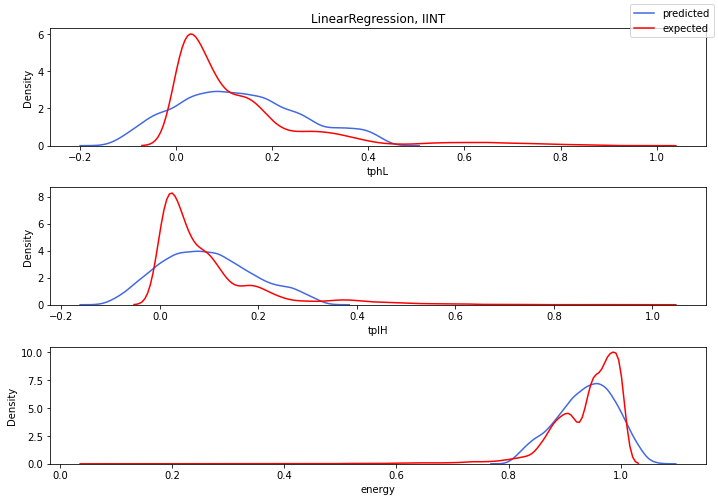

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [75]:
clfs = [LinearRegression()]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'RF_all_best_hyperparams_inverter.pdf')
plt.show()


"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

### SVR RBF

label: TPHL
clf: SVR, mse: 0.001946093399418092, r2: 0.9162398413667563
label: TPLH
clf: SVR, mse: 0.0016972211746024714, r2: 0.8683495487988447
label: IINT
clf: SVR, mse: 0.002426227117814842, r2: 0.4720222080196347


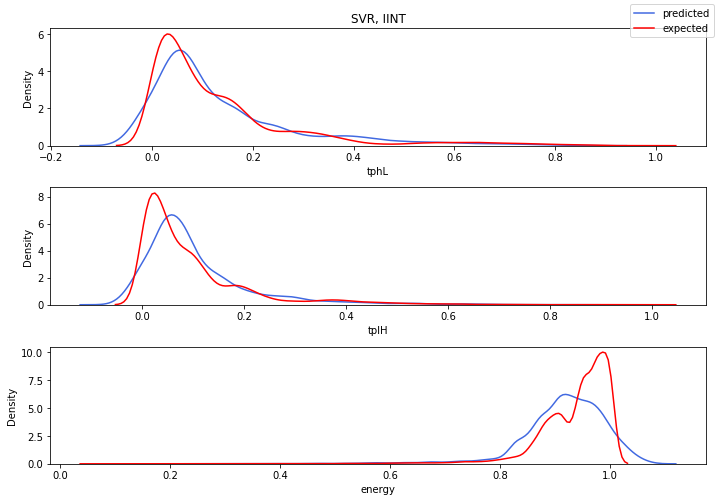

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [77]:
clfs = [SVR(kernel='rbf')]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'RF_all_best_hyperparams_inverter.pdf')
plt.show()


"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [73]:
params = {'gamma': [.03125, .0625, .125, .25, 4],
          'C': [.25, .5, 1, 2, 10]}

SVR_model_cv_gs = SVR(kernel='rbf')

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(SVR_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

#### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_TPHL[SVR_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_TPLH[SVR_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
SVR_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     SVR_cv_results_iint[SVR_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'C': 2, 'gamma': 0.03125}
Average Score on train set: 0.303 +/- 0.002
Average Score on validation set: 0.301 +/- 0.006

 Best hyperparameters:
{'C': 2, 'gamma': 0.03125}
Average Score on train set: 0.290 +/- 0.007
Average Score on validation set: 0.285 +/- 0.006

 Best hyperparameters:
{'C': 10, 'gamma': 4}
Average Score on train set: 0.416 +/- 0.007
Average Score on validation set: 0.412 +/- 0.024


label: TPHL
clf: SVR, mse: 0.001863924492952078, r2: 0.919776403713852
label: TPLH
clf: SVR, mse: 0.002201358335485763, r2: 0.8292445189472699
label: IINT
clf: SVR, mse: 0.006351492428831104, r2: -0.38216530667355797


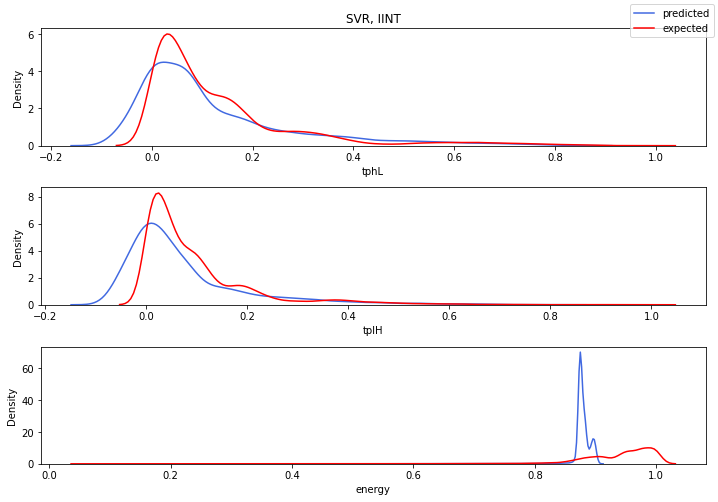

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [76]:
clfs = [SVR(kernel='rbf')]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("\n ==== metrics_after_cv ====")
#modelos para TPHL
print('label: TPHL')
logging.info('\nlabel: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(C = 2,
                   gamma = 0.03125)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
logging.info('\nlabel: TPLH')
print('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(C = 2,
                   gamma = 0.03125)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, TPLH')

#modelos para IINT
logging.info('\nlabel: IINT')
print('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(C = 10,
                   gamma = 4)
    clf = clf.fit(X_train, y_train.energy)
    
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, IINT')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
#plt.savefig(results_dir + 'RF_all_best_hyperparams_inverter.pdf')
plt.show()


"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [ ]:
SVR_cv_results_TPHL("SVR_tphL_HyperParameters.csv")
SVR_cv_results_TPLH("SVR_tplH_HyperParameters.csv")
SVR_cv_results_iint.to_csv("SVR_energy_HyperParameters.csv")

In [ ]:
SVR_model_cv_gs = SVR(kernel='rbf', random_state = seed)

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""
                           
# treinando um modelo com a melhor combinação de hiperparâmetros
SVR_model_cv_gs.fit(X_scal_training, y_scal_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [ ]:
y_scal_pred = SVR_model_cv_gs.predict(X_scal_test)

In [ ]:
print(np.concatenate((y_scal_pred.reshape(len(y_scal_pred),3), y_scal_test.reshape(len(y_scal_test),3)), axis=1))

# Neural Networks

In [ ]:
import tensorflow as tf

## Neural Net #0 (Try hard mode)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

###**TPHL**

In [ ]:
ann.fit(X_train,y_train.tphl, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0054
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.3023e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3005e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.0970e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 9.3712e-05
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.6630e-05
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.4781e-05
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.2229e-05
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.0173e-05
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.6979e-05
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.4878e-05
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tphl, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 5.659724973517145e-05


Text(0.5, 1.0, 'ANN, TPHL')

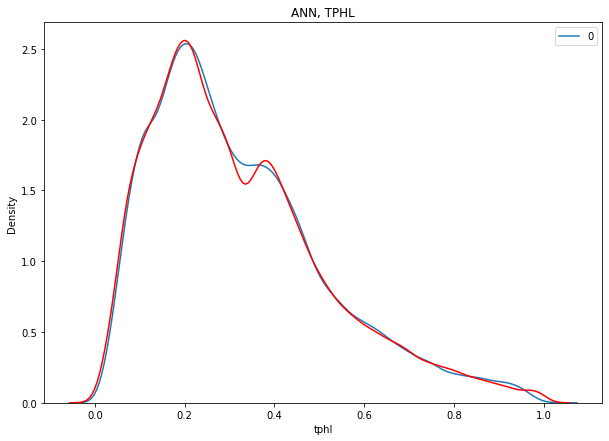

In [ ]:
fig_tphl, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPHL')

###**TPLH**

In [ ]:
ann.fit(X_train,y_train.tplh, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 5.3271e-04
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.6928e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.5479e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4872e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4467e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4033e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3642e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3444e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3278e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3065e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3020e-04
Epoch 12/50
5777/5777 [==================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tplh, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00010841889629696702


Text(0.5, 1.0, 'ANN, TPLH')

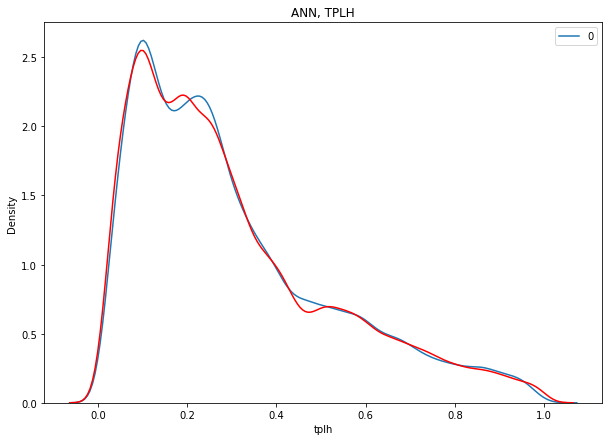

In [ ]:
fig_tplh, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPLH')

###**IINT**

In [ ]:
ann.fit(X_train,y_train.iint, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0015
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 3.2178e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.9526e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.8470e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7587e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7122e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6758e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6661e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6319e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.5917e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.4992e-04
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.iint, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00016256548097748116


Text(0.5, 1.0, 'ANN, IINT')

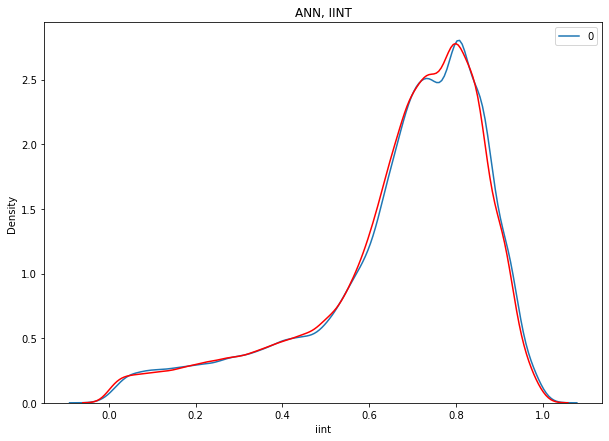

In [ ]:
fig_iint, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, IINT')

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100, ),
                                    early_stopping = True, )

###TPHL

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tphl, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0012760736147303222


Text(0.5, 1.0, 'MLP, TPHL')

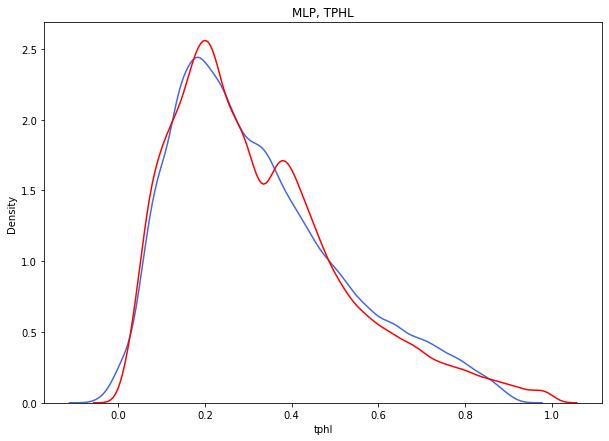

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPHL')

Score on training set: 0.967
Score on validation set: 0.967
Mean squared error (MSE): 0.0012760736147303222


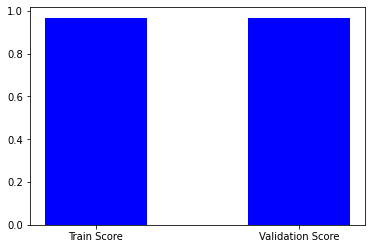

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tphl)))
y = [neural_network_model.score(X_train, y_train.tphl), 
     neural_network_model.score(X_val, y_val.tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tphl, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###TPLH

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tplh)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tplh, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0003523014496010987


Text(0.5, 1.0, 'MLP, TPLH')

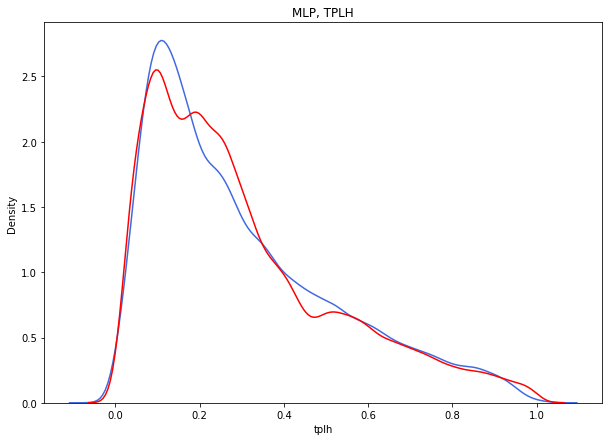

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPLH')

Score on training set: 0.993
Score on validation set: 0.993
Mean squared error (MSE): 0.0003523014496010987


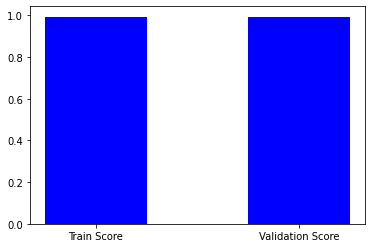

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tplh)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tplh)))
y = [neural_network_model.score(X_train, y_train.tplh), 
     neural_network_model.score(X_val, y_val.tplh)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tplh, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###IINT

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.iint)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.iint, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0005599333245738104


Text(0.5, 1.0, 'MLP, IINT')

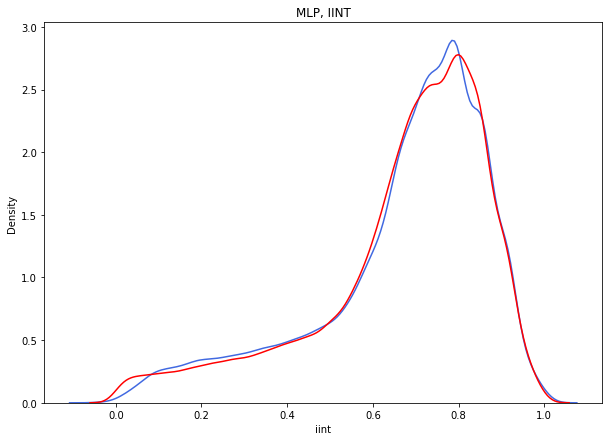

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, IINT')

Score on training set: 0.987
Score on validation set: 0.987
Mean squared error (MSE): 0.0005599333245738104


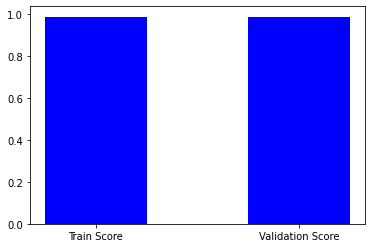

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.iint)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.iint)))
y = [neural_network_model.score(X_train, y_train.iint), 
     neural_network_model.score(X_val, y_val.iint)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.iint, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

# Old Models



## Neural Net #0 (Try hard mode)

In [ ]:
import tensorflow as tf

In [ ]:
ann = tf.keras.models.Sequential()

Vou fazer apenas um output inicialmente (tphl, coluna 0) para ver como performa, abaixo é o código para a arquitetura e compilação com backpropagation. Vou fazer sem padronizar os dados de treinamento inicialmente

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
validation_tphl = y_val.tphl
train_tphl = y_train.tphl
test_tphl = yte

Bruh, o loss diminuiu bastante e até convergiu no epoch 6, mas as predições estão constantes... wtf? Tentarei normalizar, vamos ver se altera algo, se não é mexer na arquitetura pq o modelo não está aprendendo. Aparentemente o sem alterar os dados convergiu no 30 epoch tmb. Scheisse. A normalização ainda converge, porém os resultados constantes são mais próximos da escala esperada. Vou trabalhar com ela e ver se altero a arquitetura e outros parãmetros como o batch size. O batch size e as units não me parecem trazer alterações relevantes. Vou adicionar mais Layers na esperança de a ann aprender algo a mais, minha última alternativa é alterar a composição do dataset. O aumento para 4 layers com 12 units piorou os resultados

In [ ]:
ann.fit(X_train,train_tphl, batch_size=40, epochs=50)

In [ ]:
y_pred_nn0 = ann.predict(X_val)
#np.set_printoptions(precision=2)
print(np.concatenate((y_pred_nn0.reshape(len(y_pred_nn0),1), a.reshape(len(a),1)), axis=1))

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)"""

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_norm, train_tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_norm)

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[-1.35e-04  9.68e-12]
 [ 1.02e-04  1.35e-11]
 [-5.48e-03  7.57e-12]
 ...
 [-1.57e-04  8.69e-12]
 [-1.75e-04  1.37e-11]
 [-1.91e-04  5.91e-12]]


Score on training set: -598198417686226560.000
Score on validation set: -601938109190083200.000
Explained variance score: -6.019363056862876e+17
Mean absolute error (MAE): 0.002912541559344496
Mean squared error (MSE): 1.3897360339482752e-05
R² Score: -601938109190083200.000


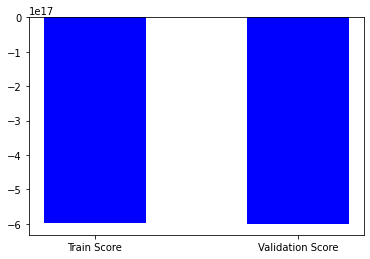

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_norm, train_tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_norm, validation_tphl)))
y = [neural_network_model.score(X_train_norm, train_tphl), 
     neural_network_model.score(X_val_norm, validation_tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {}".format(explained_variance_score(validation_tphl, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(validation_tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(validation_tphl, y_pred)))
print("R² Score: {:.3f}".format(r2_score(validation_tphl, y_pred)))

##Neural Net #2 (Keras with multioutput)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model
  
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = 7, 3
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

TypeError: ignored

In [ ]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction for new data
yhat = model.predict(X_val)
print('Predicted: %s' % yhat[0])

## Random Forest MultiOutput

In [ ]:
##### RandomForest tphl
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_model =  MultiOutputRegressor(RandomForestRegressor(random_state=seed)).fit(X_train, y_train)

y_pred_1 = rf_model.predict(X_val)

In [ ]:
print(np.concatenate((y_pred_1.reshape(len(y_pred_1),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.25e-11  2.34e-11 -1.46e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, y_pred_1, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, y_pred_1, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [5.33e-15 1.89e-15 2.00e-15]
Mean absolute error (MAE): [3.85e-12 1.14e-11 3.63e-16]
Mean squared error (MSE): [2.31e-23 2.03e-22 2.25e-31]


In [ ]:
from sklearn.model_selection import GridSearchCV
"""
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 7],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) """

'\nparams = {\'n_estimators\': [5, 50, 100, 500],\n          \'max_features\': [2, 5, 7],\n          \'max_depth\': [2, 5, 10, 50],\n          \'min_samples_split\': [2, 8, 15, 30],}\n\n# criando o objeto do modelo com RandomForestRegressor\nrf_model_cv_gs = RandomForestRegressor(random_state = seed)\n\n# criando o objeto do grid search com GridSearchCV\ngrid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3\n\n# treinando o modelo com o grid search\ngrid_search.fit(X_training, y_training)\n\n# imprimindo a melhor combinação de hiperparâmetros\nprint(\'\n Best hyperparameters:\')\nprint(grid_search.best_params_)\n\n# pegando os resultados da validação cruzada (cv_results)\ncv_results = pd.DataFrame(grid_search.cv_results_)\n\n# imprimindo o score médio nas bases de treino\nprint("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],\n                  

In [ ]:
"""Best hyperparameters:
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
Average Score on train set: -0.000 +/- 0.000
Average Score on validation set: -0.000 +/- 0.000"""

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""

rf_model_cv_gs = RandomForestRegressor(random_state = seed)

rf_model_cv_gs.set_params(n_estimators = 100,
                           max_features = 2,
                           max_depth = 2,
                           min_samples_split = 2)
# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalize(X_training), y_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [ ]:
pred = rf_model_cv_gs.predict(normalize(X_test))
print(np.concatenate((pred.reshape(len(pred),3), y_test.reshape(len(y_test),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  6.59e-12  7.30e-12 -2.95e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.78e-12  5.21e-12 -1.90e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  9.29e-12  1.76e-11 -1.44e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.86e-12  1.34e-11 -1.41e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.53e-11  2.20e-11 -1.52e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.49e-12  5.95e-12 -1.60e-15]]


##SVR Polynomial MultiOutput


In [ ]:
from sklearn.svm import SVR
SVR = MultiOutputRegressor(SVR(kernel = 'linear')).fit(normalize(X_train), y_train) # kernel='rbf', C, gamma
svr_pred = SVR.predict(normalize(X_val))

In [ ]:
print(np.concatenate((svr_pred.reshape(len(svr_pred),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.68e-11  3.61e-11 -1.85e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.68e-11  3.61e-11 -1.85e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.68e-11  3.61e-11 -1.85e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, svr_pred, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, svr_pred, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, svr_pred, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [ 5.44e-15  1.89e-15 -6.66e-16]
Mean absolute error (MAE): [5.68e-12 1.71e-11 5.51e-16]
Mean squared error (MSE): [4.19e-23 3.64e-22 3.75e-31]


# Results

In [ ]:
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
def generate_model_scores_df(score,y_pred,model_name,new_df=True,df=None):
  if new_df:
    result = pd.DataFrame(columns=['TPHL', 'TPLH', 'IINT'], index=[model_name])
  else:
    result = df
  result.loc[model_name] = score(y_val, y_pred, multioutput='raw_values')
  return result

In [ ]:
sim_0 = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/results_sim0.csv')

In [ ]:
#regre = mean_absolute_error(y_val, y_p, multioutput='raw_values')
randf1 = mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')
#randf2 = mean_absolute_error(y_val, y_pred_2, multioutput='raw_values')
NN = mean_absolute_error(y_val,y_pred, multioutput='raw_values')
#NN2 = mean_absolute_error(y_val,yhat, multioutput='raw_values')

In [ ]:
metricas = pd.DataFrame([randf1,NN],index=['Floresta','MLP'],columns=['tphl','tplh','iint'])

In [ ]:
metricas

,tphl,tplh,iint
Floresta,3.846058e-12,1.137435e-11,3.628414e-16
MLP,3.030069e-04,8.922528e-05,9.800367e-05
